# Notes

* This notebook shows how to use the growth decompositions in Chapter 2 of _Data Science: The Hard Parts_
* We will cover the three decompositions: additive, multiplicative, mix-rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {
        'titlesize' : 22,
        'labelsize' : 20}
matplotlib.rc('font', **font)  # pass in the font dict as kwargs
matplotlib.rc('axes', **axes)  # pass in the font dict as kwargs


## Additive Decomposition

In [2]:
def simulate_ar1_timeseries(T, parameter_dict, seed):
    """
    Simulate a simple AR1 time series with a trend
    T (int): size of the time series
    parameter_dict (dict): dictionary with intercept, ar1 coeff, trend component and variance for noise
    seed (int): for the random drawing
    """
    # parameters
    var_epsilon = parameter_dict['variance']
    intercept = parameter_dict['intercept']
    trend = parameter_dict['trend']
    ar1 = parameter_dict['ar1']
    # draw random normal noise ~N(0, var_epsilon)
    np.random.seed(seed)
    epsilon = np.sqrt(var_epsilon)*np.random.normal(size = T)
    # data-generating process (dgp)
    linear_trend = np.arange(T)
    y = pd.Series(index = linear_trend, name = 'y', dtype = 'float')
    for t, time in enumerate(linear_trend):
        prey = intercept + trend*time + epsilon[t]
        if t==0:
            y.loc[t] = prey
        else:
            y.loc[t] = ar1*y.loc[t-1] + prey
    return y

Text(0.5, 1.0, 'Test Time Series')

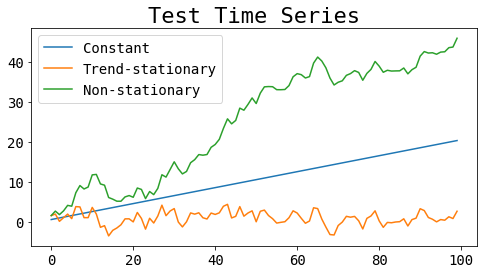

In [3]:
# test the function and plot
# several ways to test by fixing some parameters that give well known properties
T = 100
seed = 1224
# constant function
parameter_dict = {'intercept': 0.5, 'ar1': 0.0, 'trend':0.2, 'variance':0}
y_test0 = simulate_ar1_timeseries(T, parameter_dict, seed)
# no trend, just stationary AR(1)
parameter_dict = {'intercept': 0.5, 'ar1': 0.5, 'trend':0, 'variance':2}
y_test1 = simulate_ar1_timeseries(T, parameter_dict, seed)
# no trend, non-stationary AR(1)
parameter_dict = {'intercept': 0.5, 'ar1': 1, 'trend':0, 'variance':2}
y_test2 = simulate_ar1_timeseries(T, parameter_dict, seed)

fig,ax = plt.subplots(figsize = (8,4))
ax.plot(y_test0)
ax.plot(y_test1)
ax.plot(y_test2)
ax.legend(['Constant','Trend-stationary', 'Non-stationary'])
ax.set_title('Test Time Series')

In [4]:
# simulate two inputs for only two time periods
T = 2
parameter_dict1 = {'intercept': 0.5, 'ar1': 0.5, 'trend':0.3, 'variance':2}
y1 = simulate_ar1_timeseries(T, parameter_dict = parameter_dict1, seed = seed)
parameter_dict2 = {'intercept': 0.5, 'ar1': 0.9, 'trend':-0.1, 'variance':3}
y2 = simulate_ar1_timeseries(T, parameter_dict = parameter_dict2, seed = seed)
time = range(T)
y = y1 + y2
yarr = np.array([y,y1,y2]).T
df = pd.DataFrame(yarr, index = time, columns = ['y','y1','y2'])
df

,y,y1,y2
0,3.202225,1.489877,1.712347
1,4.873033,2.168373,2.704660


In [5]:
# compute shares
shares = df.div(df.y, axis = 0)
shares_lag = shares.shift(1)
shares_lag

,y,y1,y2
0,NaN,NaN,NaN
1,1.0,0.465263,0.534737


In [6]:
# compute growth rates
gr_rate = df.div(df.shift(1)) - 1
gr_rate

,y,y1,y2
0,NaN,NaN,NaN
1,0.521765,0.455404,0.579505


In [7]:
# pre decomposition: get components and test that we get the exact same result
pre_decom = gr_rate*shares_lag
pre_decom['sum_test'] = pre_decom[['y1', 'y2']].sum(axis=1)
pre_decom['test_bool'] = np.abs(pre_decom.y - pre_decom.sum_test) < 0.000001
pre_decom

,y,y1,y2,sum_test,test_bool
0,NaN,NaN,NaN,0.000000,False
1,0.521765,0.211883,0.309882,0.521765,True


In [110]:
def plot_waterfall_growth(df_for_plot, ax, fig_title = ''):
    '''
    Create a waterfall plot for growth rates
    DF: df with final 
    '''
    bottom = 0
    for c, col in enumerate(df_for_plot.columns):
        height = bottom + df_for_plot[col].values[0]
        delta = height-bottom
        ax.bar(c, bottom = bottom, height = delta, color = 'b', edgecolor = 'k', alpha = 0.5)
        value_str = str(np.around(delta, decimals=1))
        verticalalignment = 'bottom'
        if delta < 0:
            verticalalignment = 'top'
        ax.text(c, height, value_str, horizontalalignment = 'center', 
                verticalalignment = verticalalignment)
        bottom = height
    # sum of effects
    ax.bar(c+1, height, color = 'r', alpha = 0.5, edgecolor = 'k')
    ax.text(c+1, height, str(np.around(height, decimals =1)), horizontalalignment = 'center',
                   verticalalignment = verticalalignment)
    # fix xticklabels
    ax.set_xticks(range(c+2))
    xticklabs = list(df_for_plot.columns) + ['total']
    ax.set_xticklabels(xticklabs)
    # fit axis
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [0,0], ls = '--', color = '0.3')
    ax.axis([xmin, xmax, 1.05*ymin, ymax*1.05])
    
    ax.set_title(fig_title)
    return ax

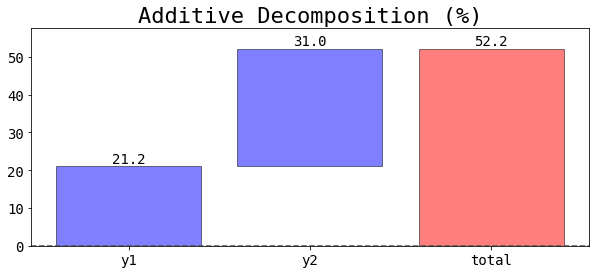

In [111]:
df_for_plot = 100*pd.DataFrame(pre_decom[['y1','y2']].loc[1]).T
fig, ax = plt.subplots(figsize = (10,4))
plot_waterfall_growth(df_for_plot, ax=ax, fig_title = 'Additive Decomposition (%)')

In [30]:
# let's simulate what we would get from the SQL command in the text book
regions = ['N','S', 'NW','SW']
T = 10
ts = pd.date_range(start = pd.to_datetime('2021-01-01'), periods = T, freq ='MS')
df_reg = pd.DataFrame(index = ts, columns = regions)
ar1_arr = [0.5, 0.8, 0.5, 0.2]
trend_arr = [0.5, 0.4, 0.01, 1]
for r, reg in enumerate(regions):
    ar1 = ar1_arr[r]
    trend = trend_arr[r]
    parameter_dict_r = {'intercept': 0.5, 'ar1': ar1, 'trend':trend, 'variance':2}
    df_reg[reg] = simulate_ar1_timeseries(T, parameter_dict = parameter_dict_r, seed = seed).values
# reorganize to get output similar to SQL
df_reg = pd.DataFrame(df_reg.stack()).reset_index()    
df_reg.columns = ['month', 'region', 'sales']
df_reg.head()

,month,region,sales
0,2021-01-01,N,1.489877
1,2021-01-01,S,1.489877
2,2021-01-01,NW,1.489877
3,2021-01-01,SW,1.489877
4,2021-02-01,N,2.368373


In [64]:
def compute_additive_decomposition_sql(df):
    """
    Compute additive decomposition for a given month
    """
    # compute necessary inputs: first reshape to make it simpler
    col_time = df.columns[0]
    col_dim = df.columns[1]
    col_metric = df.columns[2]
    dim_values = df[col_dim].unique()
    df_reshaped = df_reg[col_metric].groupby([df_reg[col_time], df_reg[col_dim]]).sum().unstack()
    df_reshaped['total'] = df_reshaped.sum(axis=1)
    # growth rates
    df_growth = 100*(df_reshaped/df_reshaped.shift(1) -1)
    # lagged weights
    df_weights = df_reshaped.div(df_reshaped.total, axis=0).shift(1)
    # contributions and check that decomposition was done correctly
    df_contrib = df_growth*df_weights
    abs_diffs_max = np.abs(df_growth.total - df_contrib.total).max()
    print(f'Maximum absolut diff was = {abs_diffs_max}')
    # keep only the contributions
    df_nice = df_contrib[dim_values]
    return df_nice

In [65]:
test = compute_additive_decomposition_sql(df = df_reg)
test.head()

Maximum absolut diff was = 0.0


region,N,S,NW,SW
month,,,,
2021-01-01,NaN,NaN,NaN,NaN
2021-02-01,14.741073,20.563083,6.518920,15.631026
2021-03-01,-11.351857,-6.650843,-19.184762,-8.718949
2021-04-01,35.182374,33.869007,18.288710,52.302047
2021-05-01,15.097770,18.241588,7.544694,16.232694


In [123]:
def plot_additive_decomp_wfall(df, ax, month, fig_title):
    """
    Plot results of additive decomposition for a given month
    """
    df_contrib = compute_additive_decomposition_sql(df)
    df_month = pd.DataFrame(df_contrib.loc[month]).T
    # for visualization purposes: sort ascendingly
    cols_sorted = df_month.loc[month].sort_values().index
    ax = plot_waterfall_growth(df_month[cols_sorted], ax=ax, fig_title = fig_title)
    return ax

Maximum absolut diff was = 0.0


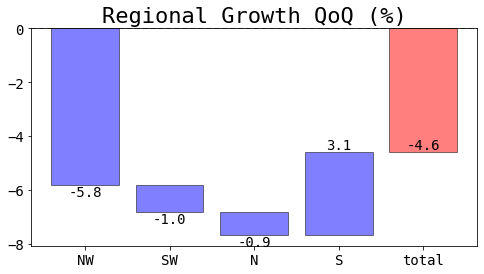

In [130]:
fig, ax = plt.subplots(figsize = (8,4))
plot_additive_decomp_wfall(df = df_reg, ax = ax, month = '2021-06-01', fig_title = 'Regional Growth QoQ (%)')

## Multiplicative Decomposition

* Let's simulate revenues and MAU to get ARPUxMAU decomposition

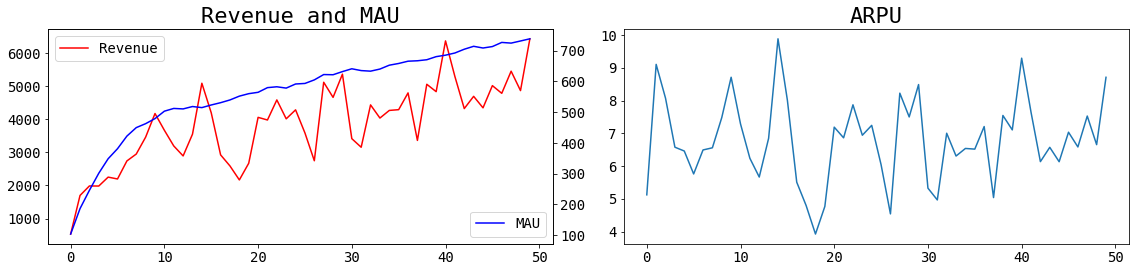

In [156]:
T = 50
# mau
parameter_dict_mau = {'intercept': 100, 'ar1': 0.8, 'trend':1, 'variance':30}
mau =  simulate_ar1_timeseries(T, parameter_dict = parameter_dict_mau, seed = seed)
# let's do revenue = N(7,2)*MAU + N(0,1)
revenues = mau*(7 + np.sqrt(2)*np.random.randn(T)) + 1*np.random.randn(T)
# arpu
arpu = revenues/mau
fig, ax = plt.subplots(1,2, figsize = (16,4))
ax[0].plot(revenues, color = 'r')
ax1 = ax[0].twinx()
ax1.plot(mau, color = 'b')
ax[0].legend(['Revenue'], loc = 2)
ax1.legend(['MAU'], loc = 4)
ax[1].plot(arpu)
ax[0].set_title('Revenue and MAU')
ax[1].set_title('ARPU')
fig.tight_layout()

In [158]:
# everything in a dataframe
df_arpu = pd.DataFrame(revenues.values, columns = ['revenue'])
df_arpu['mau'] = mau
df_arpu['arpu'] = arpu
df_arpu.head()

,revenue,mau,arpu
0,531.864946,103.833778,5.122273
1,1697.586719,186.481573,9.103241
2,1984.123408,245.836614,8.070903
3,1981.654612,301.363322,6.575633
4,2250.914600,348.502647,6.458816


In [177]:
def compute_multiplicative_decomp(df):
    """
    Compute multiplicative
    DF: includes the inputs and outputs
    """
    # Get growth rates
    df_growth = (df/df.shift(1) - 1)
    df_growth['combined_effect'] = df_growth.mau*df_growth.arpu
    # check that decomposition works
    df_growth['check'] = np.abs(df_growth.revenue - (df_growth.mau + df_growth.arpu + df_growth.combined_effect))
    max_abs_diff = df_growth.check.max()
    print(f'Max Absolute Diff = {max_abs_diff}')
    
    return df_growth

In [186]:
test_arpu = compute_multiplicative_decomp(df = df_arpu)
test_arpu.tail()

Max Absolute Diff = 3.3306690738754696e-16


,revenue,mau,arpu,combined_effect,check
45,0.154406,0.006642,0.146789,0.000975,1.387779e-16
46,-0.046278,0.018859,-0.063931,-0.001206,2.775558e-17
47,0.139780,-0.003086,0.143308,-0.000442,1.942890e-16
48,-0.107579,0.009552,-0.116023,-0.001108,1.387779e-16
49,0.321641,0.009697,0.308948,0.002996,1.110223e-16


In [181]:
def plot_multiplicative_decomp_wfall(df, ax, month, fig_title, cols_inputs):
    """
    Plot results of multiplicative decomposition for a given month
    DF: df with inputs and output metric (must be multiplicative)
    ax: axis object to pass the results of the plotting
    month: month for the decomposition to be applied
    fig_title: User-passed title for the figure
    cols_inputs: labels for the columns that have the inputs
    """
    df_contrib = compute_multiplicative_decomp(df)
    # I only need inputs and combined effect
    predf = df_contrib[cols_inputs]
    df_month = 100*pd.DataFrame(predf.loc[month]).T
    # ready to plot
    ax = plot_waterfall_growth(df_month, ax=ax, fig_title = fig_title)
    return ax

Max Absolute Diff = 3.3306690738754696e-16



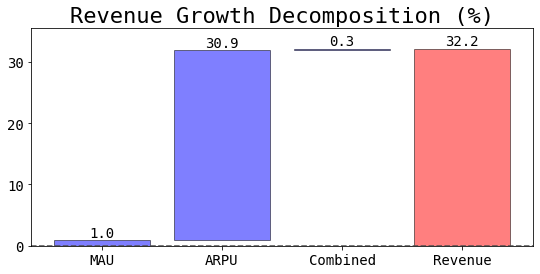

In [193]:
fig, ax = plt.subplots(figsize = (9,4))
month = df_arpu.index[-1]
fig_title = 'Revenue Growth Decomposition (%)'
cols_inputs = ['mau','arpu','combined_effect']
ax = plot_multiplicative_decomp_wfall(df = df_arpu, ax = ax, month = month, 
                                      fig_title = fig_title, cols_inputs = cols_inputs)
ax.set_xticklabels(['MAU', 'ARPU', 'Combined', 'Revenue'])
print('')

## Mix-Rate decomposition

* Let's simulate the case of several customer segments

In [239]:
# We will use a similar scenario as for the additive case (SQL)
# Idea: we have three value segments: Low Value, MV, HV
segments = ['LV','MV', 'HV']
T = 10
ts = pd.date_range(start = pd.to_datetime('2021-01-01'), periods = T, freq ='MS')
df_seg_arpu = pd.DataFrame(index = ts, columns = segments)
df_seg_share = pd.DataFrame(index = ts, columns = segments)
ar1_arr = [0.5]*3 # same AR1 coefficient
trend_arr = [0]*3 # no trend
intercept_arr = [10, 15, 30] # intercepts give the average ARPU per segment
dict_shares = {'LV': [0.6,0.7], 'MV': [0.10, 0.20], 'HV': [0, 0.1]} # draw shares from U(l,h)
for s, seg in enumerate(segments):
    ar1 = ar1_arr[s]
    trend = trend_arr[s]
    intercept = intercept_arr[s]
    # simulate ARPU
    parameter_dict_s = {'intercept': intercept, 'ar1': ar1, 'trend':trend, 'variance':2}
    df_seg_arpu[seg] = simulate_ar1_timeseries(T, parameter_dict = parameter_dict_s, seed = seed).values
    # simulate MAU to get shares
    low_s, high_s = dict_shares[seg]
    df_seg_share[seg] = np.random.uniform(low = low_s, high = high_s, size = T)
    
# get share of HV as residually:
df_seg_share['HV'] = 1 - df_seg_share[['LV', 'MV']].sum(axis =1)
# Reorganize
for d, df_s in enumerate([df_seg_arpu, df_seg_share]):
    col = 'arpu'
    if d==1:
        col = 'mau_share'
    df_s = pd.DataFrame(df_s.stack()).reset_index()
    df_s.columns = ['month', 'segment', col]
    if d==0:
        df_seg = df_s
    else:
        df_seg = df_seg.merge(df_s, on = ['month', 'segment'])
# merge both DFs and compute the weighted average
df_seg = df_seg[['arpu', 'mau_share']].groupby([df_seg.month, df_seg.segment]).sum().unstack()
df_seg['arpu_general'] = (df_seg['arpu']*df_seg['mau_share']).sum(axis=1)
df_seg.head()

arpu                       mau_share                      \
segment            HV         LV         MV        HV        LV        MV   
month                                                                       
2021-01-01  30.989877  10.989877  15.989877  0.178531  0.660734  0.160734   
2021-02-01  46.118373  16.118373  23.618373  0.100394  0.699803  0.199803   
2021-03-01  51.678172  16.678172  25.428172  0.102904  0.698548  0.198548   
2021-04-01  56.276483  18.776483  28.151483  0.258764  0.620618  0.120618   
2021-05-01  59.019213  20.269213  29.956713  0.206502  0.646749  0.146749   

           arpu_general  
segment                  
month                    
2021-01-01    15.364178  
2021-02-01    20.628711  
2021-03-01    22.017122  
2021-04-01    29.610938  
2021-05-01    29.692787

In [240]:
# test that multiplication was done correctly
df_test_seg = pd.DataFrame(index = ['LV', 'MV', 'HV'])
month_test = '2021-01-01'
df_seg['arpu'].loc[month_test]
df_test_seg['arpu_jan'] = df_seg['arpu'].loc[month_test]
df_test_seg['share_jan'] = df_seg['mau_share'].loc[month_test]
df_test_seg['avg_arpu'] = df_test_seg['arpu_jan']*df_test_seg['share_jan']
weighted_sum = df_test_seg['avg_arpu'].sum()
assert weighted_sum == df_seg.arpu_general.loc[month_test]

In [300]:
def compute_mix_decomp(df_x, df_w, df_y, lags = 1):
    '''
    Inputs:
    df_x: df with inputs by dims (eg. txn_me per readers, channels, etc)
    df_w: df with shares by dims (must be the same)
    df_y: variable we want to decompose (eg. txn_me)
    lags: number of lags to compute the deltas in time
    Compute a mix decomposition
    '''
    # Compute lags
    lag_x = df_x.shift(lags)
    lag_w = df_w.shift(lags)
    lag_y = df_y.shift(lags)
    # deltas
    delta_x = df_x - lag_x
    delta_w = df_w - lag_w
    delta_y = df_y - lag_y
    # compute three components and arrange in a DF
    cols_components = ['delta_xy', 'delta_wy', 'prod_deltas', 'check_sum','true_delta']
    df_output = pd.DataFrame(index = df_x.index, columns = cols_components)
    df_output['delta_xy'] = (lag_w * delta_x).sum(axis=1)
    df_output['delta_wy'] = (lag_x * delta_w).sum(axis=1)
    df_output['prod_deltas'] = (delta_x * delta_w).sum(axis=1)
    df_output['check_sum'] = delta_xy + delta_wy + delta_delta
    df_output['true_delta'] = delta_y.values
    # check that things add up
    df_output['abs_dif'] = np.abs(df_output.true_delta - df_output.check_sum)
    max_abs_diff = df_output.abs_dif.max()
    print(f'Max. absolute difference = {max_abs_diff} (you may want to check)')
    # arrange things for unique output
    return df_output

In [302]:
df_output = compute_mix_decomp(df_x = df_seg['arpu'], df_w = df_seg['mau_share'], 
                   df_y = pd.DataFrame(df_seg['arpu_general']), lags = 1)
df_output.tail()

Max. absolute difference = 5.551115123125783e-15 (you may want to check)


,delta_xy,delta_wy,prod_deltas,check_sum,true_delta,abs_dif
month,,,,,,
2021-06-01,-0.685611,-1.680849,-0.027110,-2.393571,-2.393571,2.664535e-15
2021-07-01,3.224449,-1.630113,-0.012937,1.581398,1.581398,5.551115e-15
2021-08-01,0.022220,5.980495,0.023545,6.026260,6.026260,2.664535e-15
2021-09-01,-2.630351,-2.546364,-0.004993,-5.181707,-5.181707,8.881784e-16
2021-10-01,0.029087,0.782697,0.000766,0.812550,0.812550,2.220446e-15


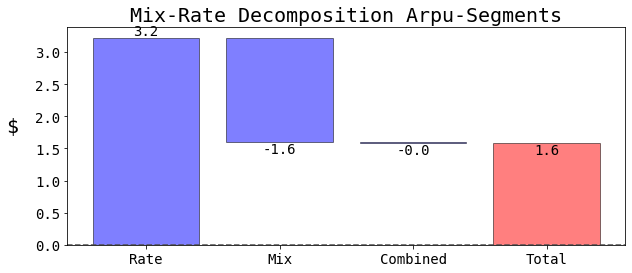

In [330]:
month_to_plot = '2021-07-01'
df_plot = df_output[['delta_xy', 'delta_wy', 'prod_deltas']].loc[month_to_plot]
df_plot = pd.DataFrame(df_plot).T
fig, ax = plt.subplots(figsize = (10,4))
title_str = "Mix-Rate Decomposition Arpu-Segments"
ax = plot_waterfall_growth(df_for_plot = df_plot, ax = ax, fig_title = title_str)
ax.set_title(title_str, fontsize = 20)
ax.set_xticklabels(['Rate', 'Mix', 'Combined', 'Total'])
ax.set_ylabel('$   ', rotation = 0)
print('')